# XGBOOST BASELINE for Semeval - Restaurants 2014

In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix, classification_report

## Preprocessing

Function to add [CLS] and [SEP] as separator tokens at beginning/ending of each text item and to format aspect and polarity columns as lists:

In [0]:
def changeFormat(dataset):

  df = pd.DataFrame(dataset)
  text = df['text']
  aspect = df['aspect']
  polarity = df['polarity']
  df2 = pd.DataFrame({'text': '[CLS] ' + text + ' [SEP]',
                    'aspect': aspect,
                    'polarity': polarity})
  
  df2['polarity'] = [x.split(',') for x in df2['polarity']]
  df2['aspect'] = [x.split(',') for x in df2['aspect']]
  
  return df2

Read csv files from Google Drive (directly from shared group drive "NLP Lab"):

In [0]:
R14_train = pd.read_csv("/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/DataPreprocessing/Data_Final/Train data/semevalRestaurants_combi14_train.csv")

Overwrite "text" column by applying "appSep" function:

In [0]:
R14_train = changeFormat(R14_train)
R14_train.head()

,text,aspect,polarity
0,[CLS] I highly recommend it. [SEP],[anecdotes/miscellaneous],[positive]
1,[CLS] so i thought why not change it up a bit....,[anecdotes/miscellaneous],[neutral]
2,[CLS] I went here in the afternoon with a frie...,[anecdotes/miscellaneous],[neutral]
3,[CLS] This place is a great bargain. [SEP],[price],[positive]
4,"[CLS] It's like they took leftover chicken, po...",[food],[negative]


In [0]:
R14_test = pd.read_csv("/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/DataPreprocessing/Data_Final/Test data/semevalRestaurants_combi14_test.csv")

In [0]:
R14_test = changeFormat(R14_test)
R14_test.head()

,text,aspect,polarity
0,[CLS] While the room is not particularly comfo...,"[food, ambience]","[positive, negative]"
1,[CLS] I went here with my boyfriend and anothe...,[anecdotes/miscellaneous],[neutral]
2,"[CLS] Granted the space is smaller than most, ...","[service, ambience]","[positive, negative]"
3,"[CLS] The well mannered, pleasant staff that T...",[service],[positive]
4,[CLS] I recently went to this restaurant with ...,[anecdotes/miscellaneous],[positive]


Shape of the train and test data:

In [0]:
R14_train.shape

(2308, 3)

In [0]:
R14_test.shape

(577, 3)

##**BERT embeddings**

Preprocessing to import BERT embeddings file of group in Colab

In [0]:
!pip install pytorch-pretrained-bert

In [0]:
!pwd

/content


In [0]:
%cd "/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/baseline"

/content/drive/My Drive/NLP Lab/Colab Notebooks/semeval/baseline


In [0]:
!ls

embeddings.py  Laptop  __pycache__  Restaurant


In [0]:
from embeddings import Embeddings

In [0]:
embed = Embeddings()

Get BERT embeddings for train and test data:

In [0]:
R14_train_embeddings = embed.get_embeddings(R14_train.text, all=False)
R14_test_embeddings = embed.get_embeddings(R14_test.text, all=False)

Plausibility check

In [0]:
# number of vectors 
len(R14_train_embeddings[0])

7

In [0]:
#string is counted letter per letter
len(R14_train['text'][0])

34

In [0]:
# original text
R14_train['text'][0]

'[CLS] I highly recommend it. [SEP]'

In [0]:
# vectors
R14_train_embeddings[0]

tensor([[ 0.0125,  0.0349, -0.1900,  ..., -0.1501,  0.4197,  0.3979],
        [ 0.0654,  0.1886, -0.4027,  ..., -0.0714,  1.3856,  0.2579],
        [ 0.2736,  0.3759, -0.3138,  ...,  0.0419,  0.7583, -0.2289],
        ...,
        [-0.1797, -0.4959, -0.4432,  ..., -0.0215, -0.0072, -0.1871],
        [ 0.7148,  0.2225, -0.2929,  ...,  0.0295, -0.4983, -0.3181],
        [-0.0968, -0.1177,  0.0639,  ...,  0.1479,  0.5210, -0.1519]])

In [0]:
len(R14_test_embeddings[0])

29

In [0]:
R14_test['text'][0]

"[CLS] While the room is not particularly comfortable, once you're seated you'll forget about everything except what's on your plate. [SEP]"

In [0]:
R14_train['embeddings'] = [e[0].numpy() for e in R14_train_embeddings]
R14_test['embeddings'] = [e[0].numpy() for e in R14_test_embeddings]

##**XGBOOST Baseline Model for Aspect**

In [54]:
R14_aspect = MultiLabelBinarizer()
R14_aspect.fit(R14_train.aspect)
R14_aspect.classes_

array(['ambience', 'anecdotes/miscellaneous', 'food', 'price', 'service'],
      dtype=object)

In [55]:
y_R14_train_aspect = R14_aspect.transform(R14_train.aspect)
y_R14_test_aspect = R14_aspect.transform(R14_test.aspect)
y_R14_train_aspect[3]

array([0, 0, 0, 1, 0])

In [56]:
R14_xgb_aspect = OneVsRestClassifier(XGBClassifier(objective='binary:logistic', n_estimators=500 , max_depth=3,
                                               learning_rate=0.05, n_jobs=24, verbosity=1,
                                               min_child_weight=20, scale_pos_weight=6, base_score=0.2))
R14_xgb_aspect.fit(np.array(list(R14_train.embeddings)), y_R14_train_aspect)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.2, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.05,
                                            max_delta_step=0, max_depth=3,
                                            min_child_weight=20, missing=None,
                                            n_estimators=500, n_jobs=24,
                                            nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=6,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
        

In [57]:
R14_aspect_report = classification_report(y_R14_test_aspect, R14_xgb_aspect.predict(np.array(list(R14_test.embeddings))),
                            target_names=R14_aspect.classes_, output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Text(0.5, 1.0, 'Multi-label aspect classification performance')

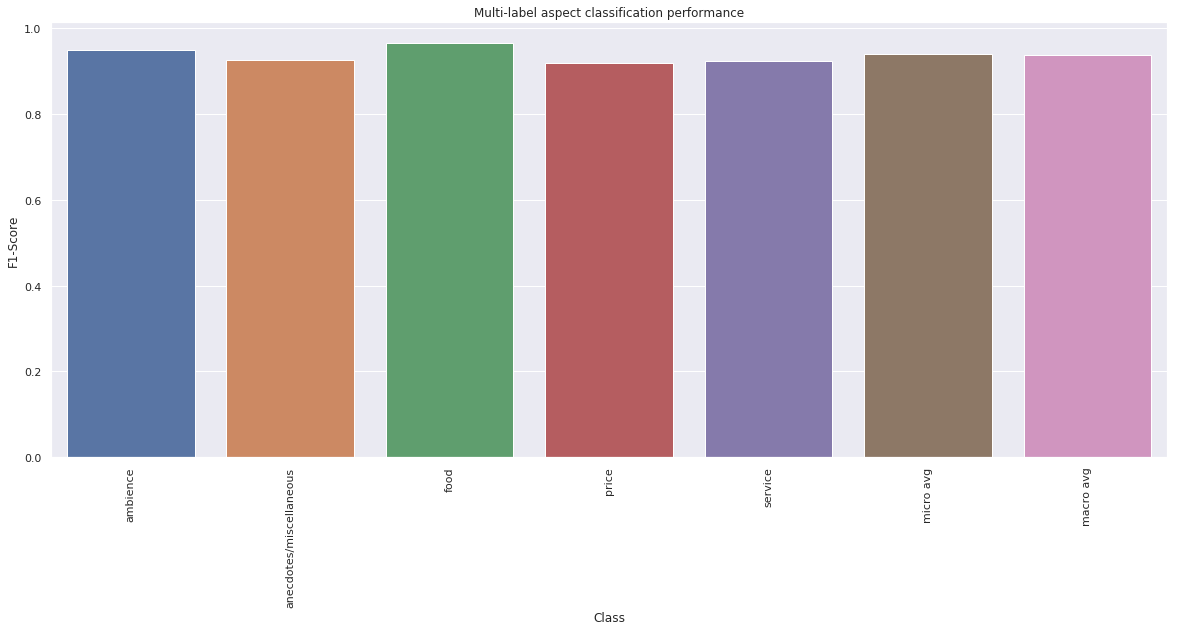

In [58]:
R14_f1s_aspect = []
for key in R14_aspect_report.keys():
    R14_f1s_aspect.append(R14_aspect_report.get(key).get('f1-score'))

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(list(R14_aspect_report.keys())[:-2], R14_f1s_aspect[:-2], palette='deep')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('Multi-label aspect classification performance')

[Text(0.9496402877697843, 0, '0.95'),
 Text(0.9269311064718162, 1, '0.93'),
 Text(0.9658119658119659, 2, '0.97'),
 Text(0.9180327868852459, 3, '0.92'),
 Text(0.9238578680203046, 4, '0.92'),
 Text(0.9409252669039146, 5, '0.94'),
 Text(0.9368548029918233, 6, '0.94')]

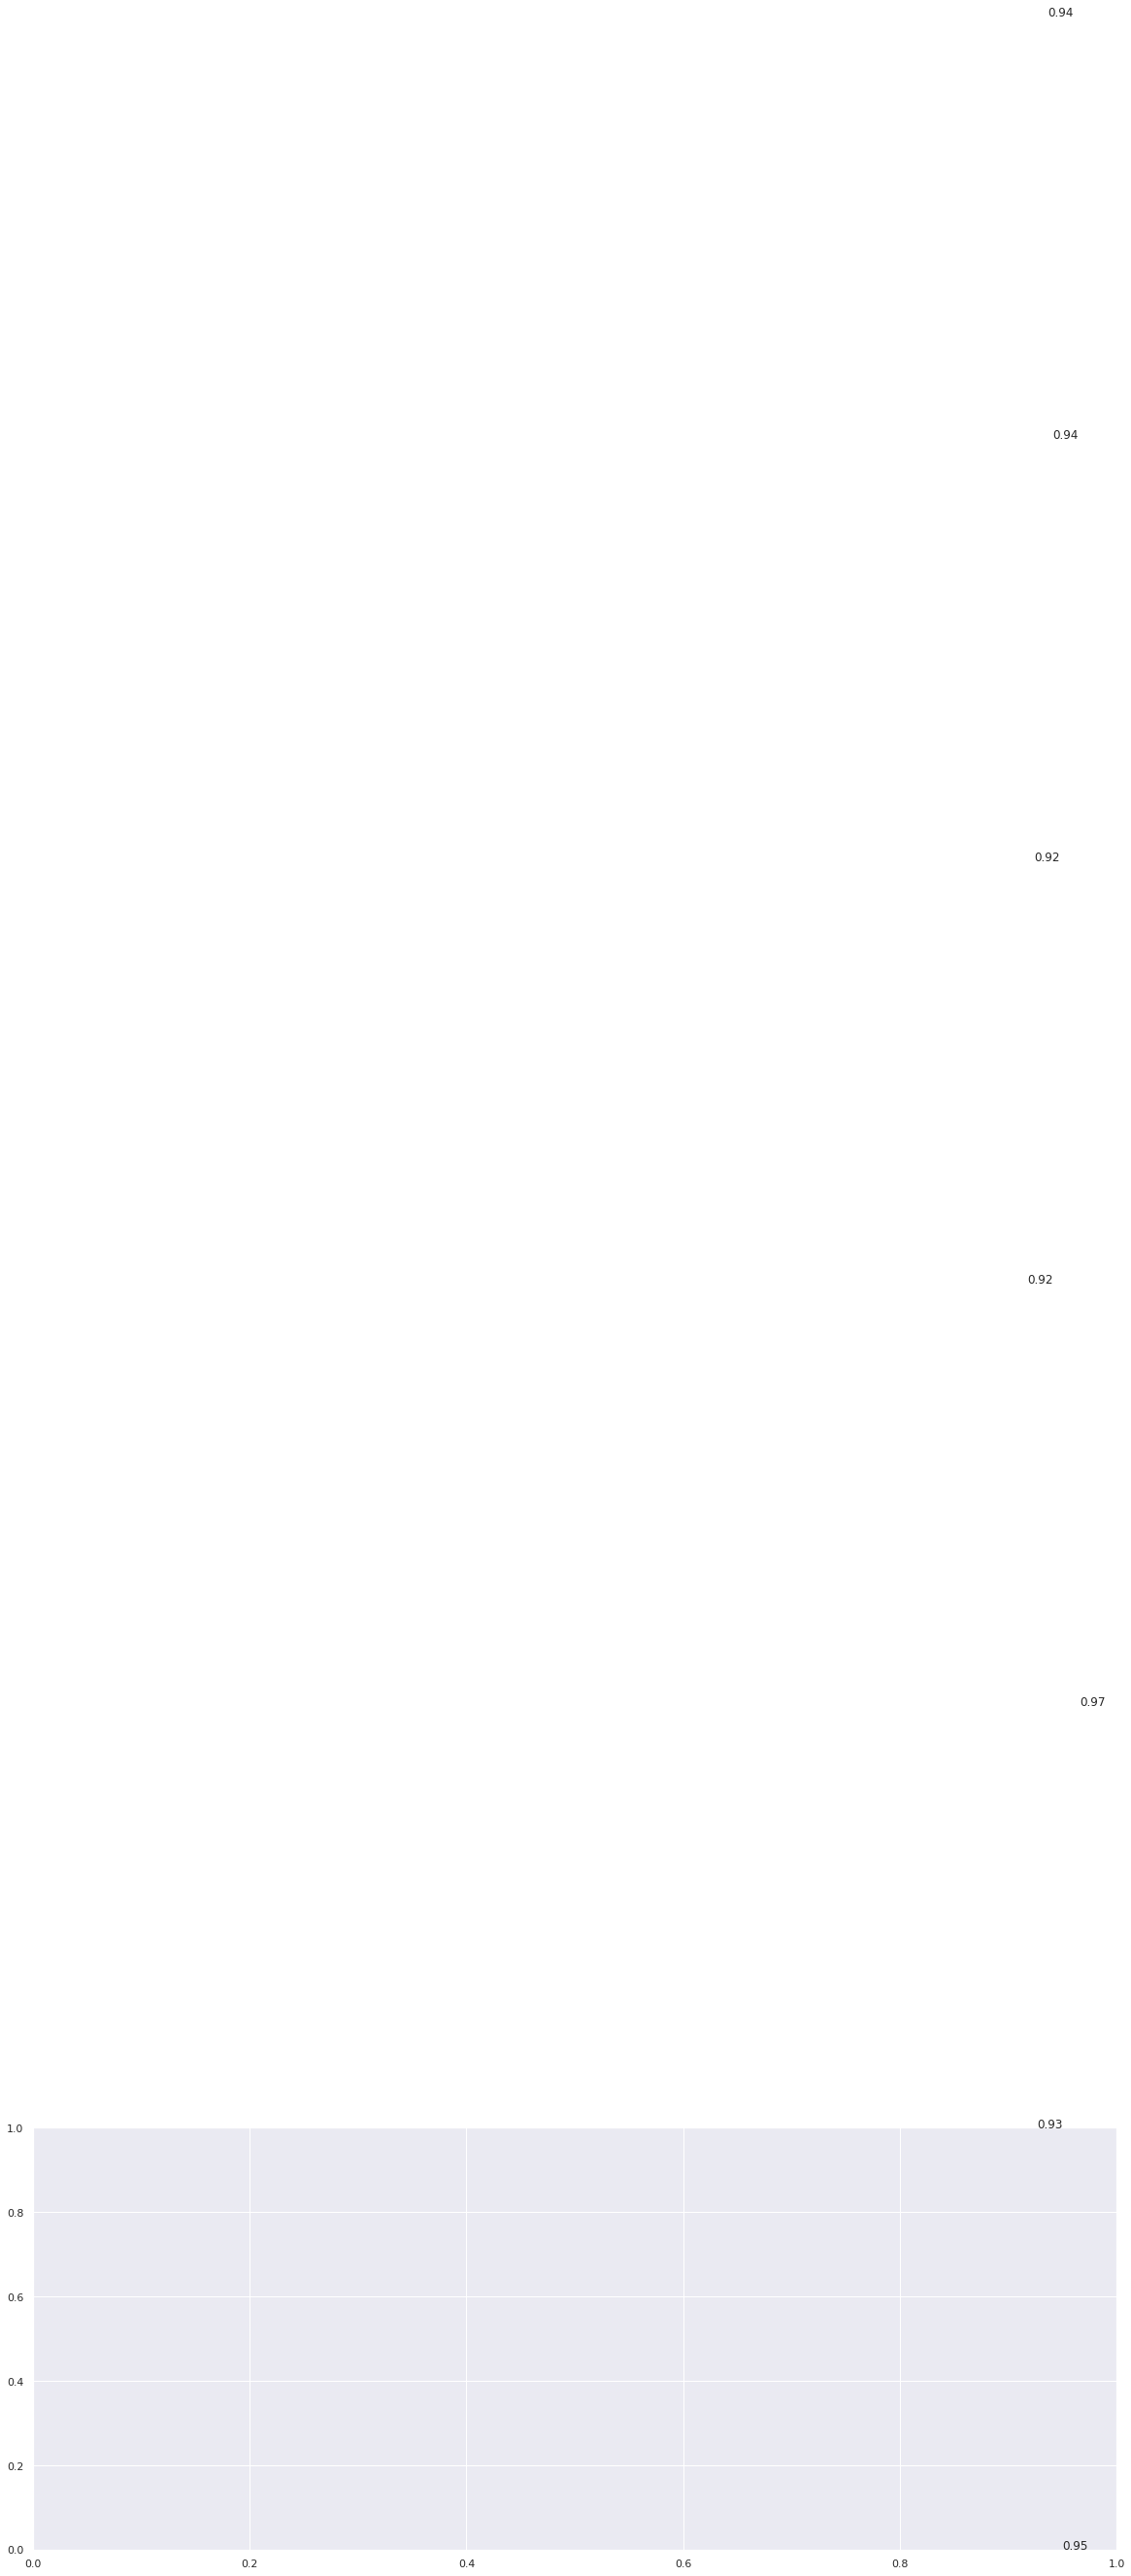

In [59]:
[plt.text(v, i, '{:.2f}'.format(v)) for i, v in enumerate(R14_f1s_aspect[:-2])]

##**XGBOOST Baseline Model for Polarity**

In [60]:
R14_polarity = MultiLabelBinarizer()
R14_polarity.fit(R14_train.polarity)
R14_polarity.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [61]:
y_R14_train_polarity = R14_polarity.transform(R14_train.polarity)
y_R14_test_polarity = R14_polarity.transform(R14_test.polarity)
y_R14_train_polarity[3]

array([0, 0, 1])

In [62]:
R14_xgb_polarity = OneVsRestClassifier(XGBClassifier(objective='binary:logistic', n_estimators=500 , max_depth=3,
                                                 learning_rate=0.05, n_jobs=24, verbosity=1, min_child_weight=50,
                                                 scale_pos_weight=6, base_score=0.3))
R14_xgb_polarity.fit(np.array(list(R14_train.embeddings)), y_R14_train_polarity)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.3, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.05,
                                            max_delta_step=0, max_depth=3,
                                            min_child_weight=50, missing=None,
                                            n_estimators=500, n_jobs=24,
                                            nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=6,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
        

In [63]:
R14_polarity_report = classification_report(y_R14_test_polarity, R14_xgb_polarity.predict(np.array(list(R14_test.embeddings))),
                            target_names=R14_polarity.classes_, output_dict=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Text(0.5, 1.0, 'Multi-label polarity classification performance')

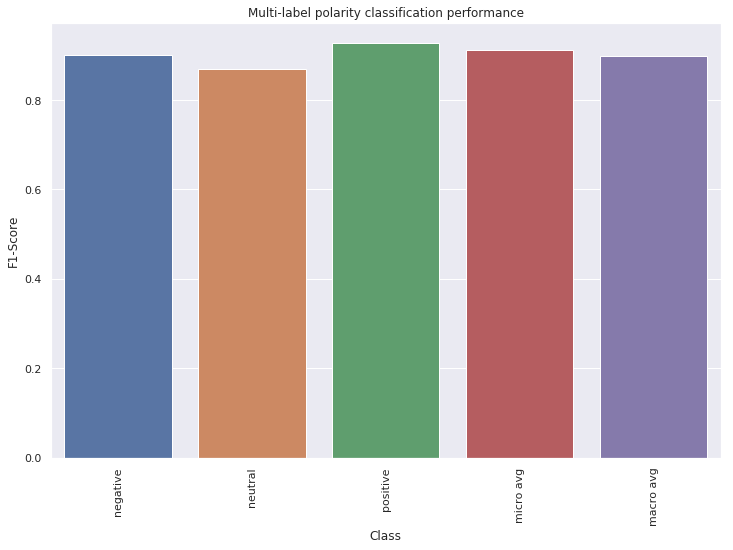

In [64]:
R14_f1s_polarity = []
for key in R14_polarity_report.keys():
    R14_f1s_polarity.append(R14_polarity_report.get(key).get('f1-score'))

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(list(R14_polarity_report.keys())[:-2], R14_f1s_polarity[:-2], palette='deep')
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('Multi-label polarity classification performance')

[Text(0.9003690036900369, 0, '0.90'),
 Text(0.8686868686868686, 1, '0.87'),
 Text(0.9267676767676767, 2, '0.93'),
 Text(0.9119746233148296, 3, '0.91'),
 Text(0.8986078497148607, 4, '0.90')]

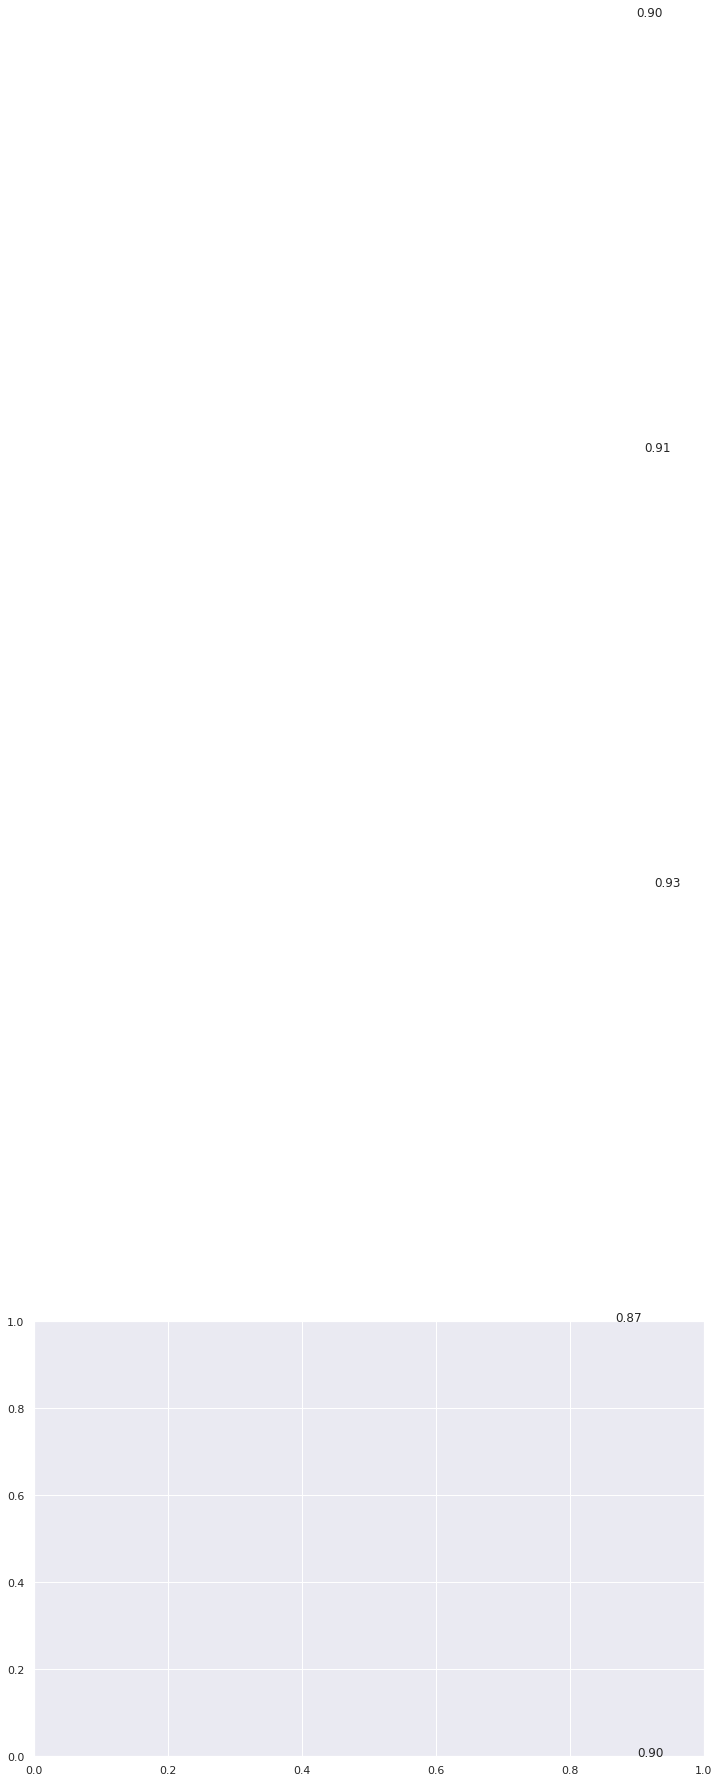

In [65]:
[plt.text(v, i, '{:.2f}'.format(v)) for i, v in enumerate(R14_f1s_polarity[:-2])]